<a href="https://colab.research.google.com/github/cgrundman/ZTM-TensorFlow-Developer/blob/main/08_nlp_fundamentals_in_tensorflow_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exerises in NLP

## Get Helper Functions

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2024-07-20 12:53:10--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-07-20 12:53:10 (66.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Get the dataset

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# Unzip data
unzip_data("nlp_getting_started.zip")

--2024-07-20 13:00:24--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.193.207, 142.250.152.207, 173.194.195.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.193.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.005s  

2024-07-20 13:00:25 (106 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



### Split the data into test and validate

In [7]:
from sklearn.model_selection import train_test_split
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [9]:
# Use train_test_split to split training data into training and validation set
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # use 10% of training data for validation data
                                                                            random_state=42)

### Create Tokenizer

In [10]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=None, # how many word in our tokenization (automatically add <OOV>)
                                    standardize='lower_and_strip_punctuation',
                                    split="whitespace",
                                    ngrams=None, # create grouos of n-words?
                                    output_mode='int', # how to map tokens to number
                                    output_sequence_length=None, # How long do you want your sequences to be
                                    pad_to_max_tokens=False)

In [11]:
# Find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [12]:
# Setup text vectorization variables
max_vocab_length = 10000 # max number of words in ourvocabulary
max_length = 15 # max length of our sequences

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [13]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [14]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [16]:
import random
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
        \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
 What the fuck was that. There was a loud bang and a flash of light outside. I'm pretty sure I'm not dead but what the hell??        

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 55,   2, 349,  23,  16,  74,  23,   3, 316, 520,   7,   3, 777,
          6, 540]])>

In [ ]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() # get all of the unique words in our vocabulary
top_5_words = words_in_vocab[:5] # get the most common words
bottom_5_words = words_in_vocab[-5:] # get the least 5 common words
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"5 most common words: {top_5_words}")
print(f"5 least common words: {bottom_5_words}")

### Create Embedding with an Embedding layer

In [17]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128,
                             input_length=max_length # how long is each input
                             )

embedding

In [18]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
        \n\nEmbedded version:")

# Embed the random sentence (turn it into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
 'cause right now I can read too good don't send me no letters no. not unless you're gonna mail them from desolation row ~        

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.03482999, -0.0095483 ,  0.04245639, ..., -0.00276804,
          0.00967957, -0.01964015],
        [ 0.02715837,  0.01230752,  0.04070952, ...,  0.04716485,
          0.0398895 , -0.02366155],
        [ 0.01167599,  0.01210435, -0.0084636 , ...,  0.02480224,
         -0.0043849 ,  0.01916032],
        ...,
        [ 0.04010022, -0.00681808, -0.01251597, ..., -0.04691039,
         -0.02556753, -0.04507679],
        [-0.03630449, -0.04135797, -0.04798383, ..., -0.01823388,
         -0.00595055,  0.01220266],
        [-0.04630087, -0.01645949,  0.01326748, ..., -0.0215145 ,
         -0.0459718 , -0.03390189]]], dtype=float32)>

In [19]:
# Check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 0.03482999, -0.0095483 ,  0.04245639,  0.0487186 , -0.04194589,
        -0.02361517, -0.03388973,  0.02940697,  0.03961224,  0.00655876,
        -0.01644622, -0.01071817, -0.01551142, -0.00322825,  0.01374351,
         0.02105333,  0.03408441, -0.018757  , -0.04545386, -0.01616811,
        -0.01447152, -0.00150635, -0.02993742,  0.04637117, -0.01681863,
         0.0435924 , -0.04368346,  0.03765244, -0.00031217, -0.00786363,
        -0.0008451 ,  0.00159701, -0.02465359,  0.00769042, -0.02262346,
         0.00621257, -0.01985139, -0.00057968,  0.03507878,  0.03919773,
         0.04079422, -0.01212623,  0.00384577,  0.01399009, -0.00950725,
         0.01507998, -0.02471443,  0.04678646,  0.03418522, -0.00013017,
         0.02263028, -0.01546031,  0.01702629, -0.03254464,  0.04243762,
        -0.01421947,  0.02389166, -0.00067278, -0.02712634, -0.01732632,
         0.01153588,  0.02733323, -0.01291064,  0.03481504, -0.03874983,
  

## Train Models

### Baseline Model

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), # convert words to numbers
    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [21]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Out baseline model achieves ana accuracy of: {baseline_score*100:.2f}%")

Out baseline model achieves ana accuracy of: 79.27%


In [22]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Function to evaluate performance

In [24]:
# Function to evaluate: accuracy, precision, recall, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_results(y_true, y_pred):
  """
  Calculate model accuracy, precision, recall, and f1 score of a binary classification model_0
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision
  model_precision = precision_score(y_true, y_pred) * 100
  # Calculate recall
  model_recall = recall_score(y_true, y_pred) * 100
  # Calculate f1_score
  model_f1 = f1_score(y_true, y_pred) * 100

  model_results = {
      "accuracy": model_accuracy,
      "precision": model_precision,
      "recall": model_recall,
      "f1": model_f1
  }

  return model_results

In [25]:
# Get Baseline Results
baseline_results = calculate_results(y_true=val_labels, y_pred=baseline_preds)

baseline_results

{'accuracy': 79.26509186351706,
 'precision': 88.6178861788618,
 'recall': 62.643678160919535,
 'f1': 73.4006734006734}

## Rebuild, Compile, and Train using the Sequential API

### Model 1

In [26]:
# Create a tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create a directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [33]:
# Build model with the Sequential API
from tensorflow.keras.layers import Input, GlobalAveragePooling1D, Dense
model_1 = tf.keras.Sequential([
    Input(shape=(1,), dtype=tf.string),
    text_vectorizer,
    embedding,
    GlobalAveragePooling1D(),
    Dense(1, activation="sigmoid")
])

In [34]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d_2  (None, 128)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 1280129 (4.88 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [35]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [36]:
# FIt the model
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20240720-131206
Epoch 1/5
215/215 [==============================] - 11s 42ms/step - loss: 0.6124 - accuracy: 0.6967 - val_loss: 0.5356 - val_accuracy: 0.7533
Epoch 2/5
215/215 [==============================] - 6s 28ms/step - loss: 0.4412 - accuracy: 0.8168 - val_loss: 0.4682 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 8s 36ms/step - loss: 0.3464 - accuracy: 0.8583 - val_loss: 0.4552 - val_accuracy: 0.7913
Epoch 4/5
215/215 [==============================] - 9s 40ms/step - loss: 0.2845 - accuracy: 0.8898 - val_loss: 0.4647 - val_accuracy: 0.7927
Epoch 5/5
215/215 [==============================] - 10s 45ms/step - loss: 0.2373 - accuracy: 0.9114 - val_loss: 0.4795 - val_accuracy: 0.7808


In [37]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 4ms/step - loss: 0.4795 - accuracy: 0.7808


[0.4795389771461487, 0.7808399200439453]

In [38]:
# Make some predictions and evaluate those
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

24/24 [==============================] - 0s 3ms/step


(762, 1)

In [39]:
# Convert model prediction probabilities to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [40]:
# Calcualate out model_1 results
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.08398950131233,
 'precision': 81.09965635738831,
 'recall': 67.81609195402298,
 'f1': 73.86541471048513}

### Model 2

In [41]:
# Create an LSTM model
from tensorflow.keras.layers import Input, LSTM, Dense
model_2 = tf.keras.Sequential([
    Input(shape=(1,), dtype="string"),
    text_vectorizer,
    embedding,
    LSTM(64),
    Dense(1, activation="sigmoid")
])

In [42]:
# Get a summary
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1329473 (5.07 MB)
Trainable params: 1329473 (5.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [43]:
# Compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [44]:
# Fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                    "model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20240720-131638
Epoch 1/5
215/215 [==============================] - 11s 37ms/step - loss: 0.2175 - accuracy: 0.9215 - val_loss: 0.5583 - val_accuracy: 0.7835
Epoch 2/5
215/215 [==============================] - 9s 42ms/step - loss: 0.1563 - accuracy: 0.9410 - val_loss: 0.5824 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 8s 37ms/step - loss: 0.1272 - accuracy: 0.9537 - val_loss: 0.7473 - val_accuracy: 0.7848
Epoch 4/5
215/215 [==============================] - 7s 31ms/step - loss: 0.1059 - accuracy: 0.9597 - val_loss: 0.8712 - val_accuracy: 0.7808
Epoch 5/5
215/215 [==============================] - 10s 45ms/step - loss: 0.0894 - accuracy: 0.9657 - val_loss: 1.0053 - val_accuracy: 0.7769


In [45]:
# Make predictions with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 [==============================] - 2s 8ms/step


array([[6.8988544e-03],
       [8.6001408e-01],
       [9.9980032e-01],
       [1.2002751e-02],
       [2.7631116e-04],
       [9.9911076e-01],
       [9.6138543e-01],
       [9.9983931e-01],
       [9.9974108e-01],
       [2.5409499e-01]], dtype=float32)

In [46]:
# Convert model 2 pred probs to lables
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [47]:
# Calculate model 2 results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 77.69028871391076,
 'precision': 80.06756756756756,
 'recall': 68.10344827586206,
 'f1': 73.60248447204968}

### Model 5

In [49]:
# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras.layers import Input, Conv1D, Dense, GlobalMaxPool1D
model_5 = tf.keras.Sequential([
    Input(shape=(1,), dtype=tf.string),
    text_vectorizer,
    embedding,
    Conv1D(filters=64, kernel_size=5, strides=1, activation="relu", padding="valid"),
    GlobalMaxPool1D(),
    Dense(1, activation="sigmoid")
])

In [50]:
# Get a summary of our Conv1D model
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1321089 (5.04 MB)
Trainable params: 1321

In [51]:
# Compile Conv1D
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [52]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_5_conv1d")])

Saving TensorBoard log files to: model_logs/model_5_conv1d/20240720-132338
Epoch 1/5
215/215 [==============================] - 13s 43ms/step - loss: 0.1511 - accuracy: 0.9458 - val_loss: 0.8132 - val_accuracy: 0.7808
Epoch 2/5
215/215 [==============================] - 10s 46ms/step - loss: 0.1012 - accuracy: 0.9637 - val_loss: 0.8897 - val_accuracy: 0.7703
Epoch 3/5
215/215 [==============================] - 8s 39ms/step - loss: 0.0809 - accuracy: 0.9688 - val_loss: 0.9646 - val_accuracy: 0.7690
Epoch 4/5
215/215 [==============================] - 9s 42ms/step - loss: 0.0689 - accuracy: 0.9752 - val_loss: 1.0689 - val_accuracy: 0.7612
Epoch 5/5
215/215 [==============================] - 7s 33ms/step - loss: 0.0619 - accuracy: 0.9759 - val_loss: 1.0548 - val_accuracy: 0.7572


In [53]:
# Make some predictions with our Conv1D model
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 4ms/step


array([[6.4124215e-01],
       [8.9260840e-01],
       [9.9996716e-01],
       [4.9132604e-02],
       [2.0629600e-06],
       [9.9918932e-01],
       [9.8859787e-01],
       [9.9996901e-01],
       [9.9999821e-01],
       [7.5033754e-01]], dtype=float32)

In [54]:
# Convert model 5 pred probs to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [55]:
# Evaluate model 5 predictions
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 75.7217847769029,
 'precision': 74.32835820895522,
 'recall': 71.55172413793103,
 'f1': 72.91361639824305}

### Baseline with 10% of the Data

In [56]:
#Making a better dataset split (no data leakage)
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0_10_percent = Pipeline([
    ("tfidf", TfidfVectorizer()), # convert words to numbers
    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0_10_percent.fit(train_sentences_10_percent, train_labels_10_percent)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [63]:
# Evaluate our baseline model
baseline_10_percent_score = model_0_10_percent.score(val_sentences, val_labels)
print(f"Out baseline 10 percent model achieves an accuracy of: {baseline_10_percent_score*100:.2f}%")

Out baseline 10 percent model achieves an accuracy of: 70.21%


In [64]:
# Find pred propbs for model_0_10_percent
baseline_10_percent_pred_probs = model_0_10_percent.predict(val_sentences)
baseline_10_percent_pred_probs[:10]

array([1, 0, 1, 0, 0, 1, 0, 0, 1, 0])

In [65]:
# Convert pred probs to labels
baseline_10_percent_preds = tf.squeeze(tf.round(baseline_10_percent_pred_probs))
baseline_10_percent_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([1, 0, 1, 0, 0, 1, 0, 0, 1, 0])>

In [66]:
# Get Baseline 10 percent Results
baseline_10_percent_results = calculate_results(y_true=val_labels, y_pred=baseline_10_percent_preds)

baseline_10_percent_results

{'accuracy': 70.20997375328083,
 'precision': 88.53503184713377,
 'recall': 39.94252873563218,
 'f1': 55.049504950495056}

### Model 6: Fine-Tune

In [67]:
import tensorflow_hub as hub
import tensorflow as tf
embed = hub.load("https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2")
embed_samples = embed([
    sample_sentence,
    "When you call the univeral sentence encoder on a sentence, it turns it into  numbers."])
print(embed_samples[0][:50])

tf.Tensor(
[-0.01157025  0.02485911  0.02878051 -0.012715    0.03971541  0.08827761
  0.02680988  0.05589838 -0.01068731 -0.00597293  0.00639321 -0.01819516
  0.00030816  0.09105889  0.05874645 -0.03180629  0.01512474 -0.05162925
  0.00991366 -0.06865345 -0.04209306  0.0267898   0.03011009  0.00321065
 -0.00337968 -0.04787356  0.0226672  -0.00985927 -0.04063615 -0.01292093
 -0.04666382  0.05630299 -0.03949255  0.00517682  0.02495827 -0.07014439
  0.0287151   0.0494768  -0.00633978 -0.08960193  0.02807119 -0.00808364
 -0.01360601  0.05998649 -0.10361788 -0.05195372  0.00232958 -0.02332531
 -0.03758106  0.03327729], shape=(50,), dtype=float32)


In [68]:
# Create a Keras Layer using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=True,
                                        name="USE_trainable")

In [71]:
# Create a model using the Sequential API
model_6_fine_tune = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid", name="output_layer")
], name="model_6_USE")

# Compile
model_6_fine_tune.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

# Get a summary
model_6_fine_tune.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE_trainable (KerasLayer)  (None, 512)               256797824 
                                                                 
 dense_8 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 256830721 (979.73 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [73]:
# # Train a classifier on top of USE pretrained embeddings
# model_6_fine_tune_history = model_6_fine_tune.fit(train_sentences,
#                                                   train_labels,
#                                                   epochs=5,
#                                                   validation_data=(val_sentences, val_labels),
#                                                   callbacks=[create_tensorboard_callback(SAVE_DIR,
#                                                                                         "model_6_USE_fine)tune")])

In [74]:
# # Make predictions with USE TF Hub Model
# model_6_fine_tune_pred_probs = model_6_fine_tune.predict(val_sentences)
# model_6_fine_tune_pred_probs[:10]

In [75]:
# # Convert prediction probabilities to labels
# model_6_fine_tune_preds = tf.squeeze(tf.round(model_6_fine_tune_pred_probs))
# model_6_fine_tune_preds[:10]

In [76]:
# # Evaluate results of the model
# model_6_results = calculate_results(y_true=val_labels,
#                                     y_pred=model_6_fine_tune_preds)
# model_6_results

## Retrain Best Model

In [77]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "baseline_10_percent": baseline_10_percent_results,
                                  "model_1_results": model_1_results,
                                  "model_2_results": model_2_results,
                                  "model_5_results": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,88.617886,62.643678,73.400673
baseline_10_percent,70.209974,88.535032,39.942529,55.049505
model_1_results,78.083990,81.099656,67.816092,73.865415
model_2_results,77.690289,80.067568,68.103448,73.602484
model_5_results,75.721785,74.328358,71.551724,72.913616


### Visualize Performance

Use a confusion matrix to visualize model performance.

In [82]:
from helper_functions import confusion_matrix

conf_mat = confusion_matrix(y_true=val_labels, y_pred=baseline_preds)

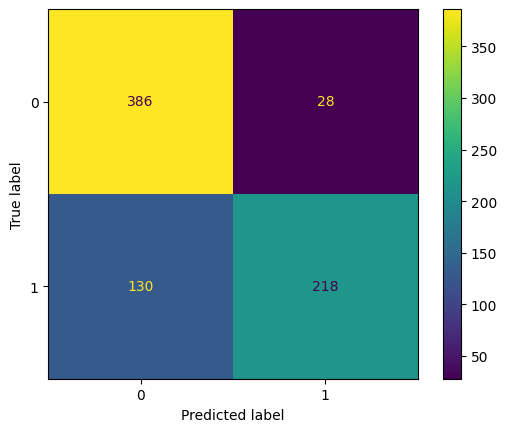

In [86]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.show()